# Tarini's Gekko test for solving OCT

In [30]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

# Initialize the model
m = GEKKO(remote=True)

# Define the number of time steps and time vector (22 days)
nt = 7 # each cycle is 7 days
m.time = np.array([i for i in range(1, nt+1)]) 

# State Variables and Parameters
C_B = m.Var(lb=0.0)  # Blood concentration in mg/L
#C_target = m.Var() # Blood level concentration in mg/L for SOC / target
M = m.Var(value=0.0)  # Total amount of drug metabolized (mg)
dose = m.Var(lb=0.0, ub=5)  # Drug administered at time t
#D_total = m.Var() # Total drug in body by time t
RC = m.Var(value=0) # Running cost (the integrand of the objective function)
p = np.zeros(nt) # mark final time point
p[-1] = 1.0
final = m.Param(value=p)

# Set constraints
dose_mask = np.zeros(nt)
dose_mask[0] = 1.0
first_dose_mask = m.Param(value=dose_mask)
m.Equation(dose * first_dose_mask >= 0.5)  # ensure nonzero first dose

# General parameters
BV = 5.0   # L
BSA = 1.9  # m²
enz_count = 5.0 # pmol 
CYP_mg_per_pmol = 5.7e-5 # mg/pmol
CYP_g_per_mol = 5.7e4 # g/mol
min_to_days = 1440.0 # minutes in a day 

# Patient-specific parameters
V_max = 3.5 * CYP_mg_per_pmol * min_to_days # Maximum rate (pmol/min/pmol P450) * CYP_mg_per_pmol (mg/pmol) = (mg/min/pmol P450)
K_m = 16.0 * CYP_g_per_mol * 1.0e-3 # Substrate concentration at half-maximal rate (mg/L)

# Equations 
m.Equation(C_B == (dose * BSA - M) / BV) # Blood concentration of vincristine
m.Equation(M.dt() == (V_max * enz_count * C_B) / (K_m + C_B))  # Michaelis-Menten kinetics
m.Equation(RC.dt() == -3.0*C_B**2 + dose**2) # Integrand of cost functional 
m.Obj(RC*final) # Objective function

# Solve the optimization problem
m.options.IMODE = 6 # optimal control mode
m.options.MAX_ITER = 1e6
m.options.SOLVER = 1  # APOPT solver+
m.solve(disp=False, debug=True) # solve

# Plot results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes = axes.ravel()
axes[0].plot(m.time, C_B.value,'ko',label=r'$BLC$')
axes[0].legend(loc='best', fancybox=False, shadow=False, frameon=False)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('C_B (Blood Level Concentration)')
axes[0].set_xlim((0,nt))

axes[1].plot(m.time, dose.value,'ro',label=r'$dose$')
axes[1].legend(loc='best', fancybox=False, shadow=False, frameon=False)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Dose Administered')
axes[1].set_xlim((0,nt))
plt.show()

Exception:  @error: Solution Not Found


In [ ]:
# Accumulate doses over time
doses = np.zeros(nt)
dose_interval = [1, 8, 15, 22]  # Days of dose administration (1st, 8th, 15th, 22nd)

# Adjust dosing days to the correct indices (0-based indexing)
BSA = 1.9  # m²
SOC = 1.4  # mg/m² per dose
dose_amount = SOC * BSA  # mg
dose_intervals_adjusted = [i - 1 for i in dose_interval if i <= nt]  # (0th, 7th, 14th, 21st)

# Create dose schedule
for t_dose in dose_intervals_adjusted:
    doses[t_dose] = dose_amount

# Equation for accumulating doses over time (total administered dose)
m.Equation(D_total.dt() == doses[0])  # Start with first dose (initialize it)

for i in range(1, nt):
    m.Equation(D_total.dt() == doses[i] + D_total)  # Accumulate doses over time

In [31]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

# Initialize the model
m = GEKKO(remote=True)

# Define the number of time steps and time vector
t_max = 10 # each cycle is ~7 days
t_step = 0.1
m.time = np.arange(0, t_max + t_step, t_step)

# State Variables and Parameters
C_B = m.Var(lb=0.0)  # Blood concentration in mg/L
C_B_target = m.Param(value=np.full(len(m.time), 1.0)) # After preliminary implementation, I would load this in
M = m.Var(value=0.0)  # Total amount of drug metabolized (mg)
D_tot = m.Var(value=0) # Total drug in body by time t
dose = m.Var(lb=0.0, ub=7)  # Drug administered at time t
RC = m.Var(value=0) # Running cost (the integrand of the objective function)

# What time point do we want to minimize at?
p = np.zeros(len(m.time))  # mark final time point
p[-1] = 1.0
final = m.Param(value=p)

# Set constraints
mask = np.zeros(len(m.time))
mask[0] = 1.0
first_point = m.Param(value=mask)
m.Equation(dose * first_point >= 0.5)  # ensure nonzero first dose
m.Equation(C_B * first_point == (dose * first_point) / BV) # ensure nonzero first BLC
m.Equation(D_tot <= 50) # total dose cannot go over  this 

# General parameters
BV = 1.0 #5.0   # L
BSA = 1.0  # m²
enz_count = 1.0 # pmol 
CYP_mg_per_pmol = 5.7e-5 # mg/pmol
CYP_g_per_mol = 5.7e4 # g/mol
min_to_days = 1440.0 # minutes in a day 

# Patient-specific parameters
V_max = 1.0#3.5 * CYP_mg_per_pmol * min_to_days # Maximum rate (pmol/min/pmol P450) * CYP_mg_per_pmol (mg/pmol) = (mg/min/pmol P450)
K_m = 1.0 #16.0 * CYP_g_per_mol * 1.0e-3 # Substrate concentration at half-maximal rate (mg/L)

# Equations 
m.Equation(D_tot.dt() == dose)
m.Equation(M.dt() == (V_max * C_B) / (K_m + C_B))  # Michaelis-Menten kinetics
m.Equation(C_B == (D_tot * BSA - M) / BV) # Blood concentration of vincristine
m.Equation(RC.dt() == 3.0*(C_B-C_B_target)**2 + dose**2) # Integrand of cost functional 
m.Obj(RC*final) # Objective function

# Solve the optimization problem
m.options.IMODE = 6 # optimal control mode
m.options.MAX_ITER = 1e6
m.options.SOLVER = 1  # APOPT solver+
m.solve(disp=True) # solve

# Plot results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes = axes.ravel()
axes[0].plot(m.time, C_B.value,'ko',label=r'$BLC$')
axes[0].legend(loc='best', fancybox=False, shadow=False, frameon=False)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('C_B (Blood Level Concentration)')
axes[0].set_xlim((0,t_max))

axes[1].plot(m.time, dose.value,'ro',label=r'$dose$')
axes[1].legend(loc='best', fancybox=False, shadow=False, frameon=False)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Dose Administered')
axes[1].set_xlim((0,t_max))
plt.show()

apm 128.62.96.33_gk_model22 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           10
   Intermediates:            0
   Connections  :            0
   Equations    :            8
   Residuals    :            8
 
 Number of state variables:           1000
 Number of total equations: -         1000
 Number of slack variables: -          200
 ---------------------------------------
 Degrees of freedom       :           -200
 
 * Warning: DOF <= 0
 ----------------------------------------------
 Dynamic Control with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  1.33041E+04  5.00000E+01
    1  1.33041E+04  2.22045E-16
 No feasible solution
 

Exception:  @error: Solution Not Found


In [20]:
import numpy as np

def blood_level_conc(BV, k_m, V_max, dose_schedule, t_step, t_max):
    """
    Compute blood level concentration over time using Michaelis-Menten metabolism.

    Parameters:
    - BV: Blood volume (L)
    - k_m: Michaelis-Menten constant
    - V_max: Maximum metabolism rate
    - dose_schedule: Nx2 array with [time, dose] per row
    - t_step: Time step
    - t_max: Maximum simulation time

    Returns:
    - BLC: Nx2 array where each row is [time, concentration]
    """

    t = np.arange(0, t_max + t_step, t_step)

    dose_times = dose_schedule[:, 0]
    dose_amounts = dose_schedule[:, 1]

    D_tot = np.zeros_like(t)
    M = np.zeros_like(t)
    C_B = np.zeros_like(t)

    # Initial dose
    D_tot[0] = dose_amounts[0]
    M[0] = 0
    C_B[0] = dose_amounts[0] / BV

    for i in range(1, len(t)):
        C_B_temp = C_B[i - 1]
        dose = 0

        # Apply dose if at a scheduled time
        if t[i] in dose_times:
            idx = np.where(dose_times == t[i])[0][0]
            dose = dose_amounts[idx]
            C_B_temp += dose / BV

        D_tot[i] = D_tot[i - 1] + dose
        M[i] = M[i - 1] + ((V_max * C_B_temp) / (k_m + C_B_temp)) * t_step
        C_B[i] = (D_tot[i] - M[i]) / BV

    BLC = np.column_stack((t, C_B))
    return BLC


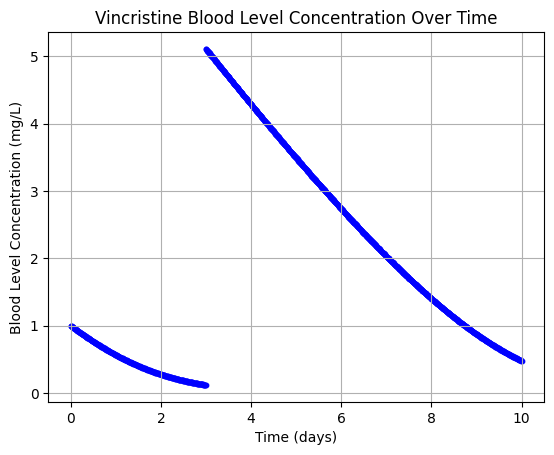

In [21]:
import matplotlib.pyplot as plt

# Parameters
BV = 1
k_m = 1
V_max = 1
dose_schedule = np.array([
    [0, 1],
    [3, 5]
])
t_step = 0.01
t_max = 10

result = blood_level_conc(BV, k_m, V_max, dose_schedule, t_step, t_max)

plt.scatter(result[:, 0], result[:, 1], s=10, color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Blood Level Concentration (mg/L)')
plt.title('Vincristine Blood Level Concentration Over Time')
plt.grid(True)
plt.show()
